# Image encryption results

This notebook contains image encryption results considering an approach fully implemented in software and also an approach that integrates the PRNG implemented in hardwar.

## 1. Software-in-the-Loop Implementation

We first install the dependencies and then execute the encryption algorithm:

In [3]:
pip install opencv-python --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Create output directory which will have encrypted images

In [4]:
mkdir output

In [1]:
%matplotlib inline
import math
from abc import ABC, abstractmethod
import numpy
import matplotlib.pyplot as plt
import softposit as sp
import cv2
import hashlib
from random import random
from PIL import Image

control_parameter = 0.962879
image_name = "airplane.tiff"
DIFF = 0
class NumberRepresentationStrategy(ABC):
    @abstractmethod
    def get_number(self, number):
        ''' Get number abstract method
        
        Convert a int/float number to the specifided number representation strategy.
        If the argument "number" is already in the target representation, it must return the number itself.
        '''
        ...

class ChaoticMap(ABC):
    def get_next_iteration(self, x_n, representation_strategy):
        return self.compute_map_equation(x_n, representation_strategy)

    def get_iterations(self, x_0, number_iterations, representation_strategy: NumberRepresentationStrategy, 
                       verbose=False):
        x_n = representation_strategy.get_number(x_0)
        iterations = [ x_n ]
        
        if verbose:
            print(x_n) # print initial value

        for k in range(number_iterations):
            next_iteration = self.get_next_iteration(x_n, representation_strategy)
            iterations.append(next_iteration)
            
            if verbose:
                print(next_iteration)
        
            x_n = next_iteration
        
        return iterations

    @abstractmethod
    def compute_map_equation(self, x_n, representation_strategy: NumberRepresentationStrategy):
        ''' Compute map equation abstract method
        
        Computes the equation of the chaotic map using the number representation strategy.
        '''
        ...

class SineMap(ChaoticMap):
    def __init__(self, control_parameter):
        self.control_parameter = control_parameter
    
    def set_control_parameter(self, value):
        self.control_parameter = value
            
    def compute_map_equation(self, x_n, representation_strategy):
        return representation_strategy.get_number(self.control_parameter) * \
            representation_strategy.sine(representation_strategy.get_number(math.pi) * representation_strategy.get_number(x_n))

class Sine():
    def __init__(self, representation_strategy):
        self.representation_strategy = representation_strategy
        self.define_weights()
        self.define_rules()
    
    def define_weights(self):
        get_number = self.representation_strategy.get_number
        self.line_a = [get_number(1/math.pi), get_number(1)]
        self.line_b = [get_number(-1/math.pi), get_number(1)]
        self.line_c = [get_number(1/math.pi), get_number(0)]
        self.line_d = [get_number(-1/math.pi), get_number(2)]
        self.line_e = [get_number(1/math.pi), get_number(-1)]
        self.line_f = [get_number(-1/math.pi), get_number(3)]
    
    def define_rules(self):
        get_number = self.representation_strategy.get_number
        self.rule_a = [get_number(2/math.pi), get_number(0)]
        self.rule_b = [get_number(-2/math.pi), get_number(2)]
        self.rule_c = [get_number(2/math.pi), get_number(-4)]
        
    def evaluateLine(self, x, parameters):
        # evaluates the value of the line y = a*x + b, at the given "x" point
        # the parameters argument needs to be an array following the pattern [a, b]
        get_number = self.representation_strategy.get_number
        
        return get_number((get_number(parameters[0]) * get_number(x)) + get_number(parameters[1]))
    
    def evaluateTriangleFunction(self, x, leftParameters, peak, rightParameters):
        get_number = self.representation_strategy.get_number
        
        if get_number(x) < get_number(peak[0]):
            evaluation = self.evaluateLine(x, leftParameters)
        else:
            evaluation = self.evaluateLine(x, rightParameters)

        return evaluation if evaluation > get_number(0) else get_number(0)
    
    def sine(self, x, verbose=False):
        get_number = self.representation_strategy.get_number
        pi = math.pi
        
        w1 = self.evaluateTriangleFunction(get_number(x), self.line_a, [get_number(0), get_number(1)], self.line_b)
        w2 = self.evaluateTriangleFunction(get_number(x), self.line_c, [get_number(pi), get_number(1)], self.line_d)
        w3 = self.evaluateTriangleFunction(get_number(x), self.line_e, [get_number(2*pi), get_number(1)], self.line_f)
        
        # evaluates the three rules of the given x value
        v1 = self.evaluateLine(get_number(x), self.rule_a)
        v2 = self.evaluateLine(get_number(x), self.rule_b)
        v3 = self.evaluateLine(get_number(x), self.rule_c)
        
        # calculates approximation
        if verbose:
            print(f'{w1} {v1} + {w2} {v2} + {w3} {v3}' )
            print("---------------------------------------------------------------------------------------------------------")
            print(f'  {w1} + {w2} + {w3}' )
            print('\n\n')
            print(f'{(get_number(-1)*get_number(x)/get_number(math.pi))+get_number(1)} {get_number(2)*get_number(x)/get_number(math.pi)} + {get_number(x)/get_number(math.pi)} {(get_number(-2)*get_number(x)/get_number(math.pi))+get_number(2)}')
            print('\n\n')
            print(f'{(((get_number(-1)*get_number(x)/get_number(math.pi))+get_number(1))*(get_number(2)*get_number(x)/get_number(math.pi))) + ((get_number(x)/get_number(math.pi))*((get_number(-2)*get_number(x)/get_number(math.pi))+get_number(2)))}')
            
            print(f'\n\n Approx = {(get_number(-4) * get_number(x) * get_number(x) / (get_number(math.pi) * get_number(math.pi))) + (get_number(4) * get_number(x)/get_number(math.pi))}')
        
        return get_number((w1*v1) + (w2*v2) + (w3*v3))
    
    def plot_weights(self):
        # Creates an array with evenly spaced values.
        pi = math.pi
        get_number = self.representation_strategy.get_number
        domainValues = numpy.asarray(numpy.arange(-pi, 2*pi + (pi), (2*pi/1000)))
        
        w1 = []
        w2 = []
        w3 = []

        for x in domainValues:
            w1.append(self.evaluateTriangleFunction(get_number(x), self.line_a, [get_number(0), get_number(1)], self.line_b))
            w2.append(self.evaluateTriangleFunction(get_number(x), self.line_c, [get_number(pi), get_number(1)], self.line_d))
            w3.append(self.evaluateTriangleFunction(get_number(x), self.line_e, [get_number(2*pi), get_number(1)], self.line_f))

        plt.xlabel("x", fontsize=20)
        plt.ylabel("y", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.plot(domainValues, w1, domainValues, w2, domainValues, w3)
        plt.legend([r'$w_1$', r'$w_2$', r'$w_3$'], fontsize=15)
        plt.savefig("images/weights", bbox_inches='tight')
        plt.show()
        
    def plot_approximation(self, verbose=False):
        # Creates an array with evenly spaced values.
        pi = math.pi
        
        domainValues = numpy.asarray(numpy.arange(0, 2*pi, (2*pi/1000)))
        approximation = [] # Approximation vector
        
        rule_1 = []
        rule_2 = []
        rule_3 = []
        
        for x in domainValues:
            evaluation = self.sine(x)
            approximation.append(evaluation)
            if verbose:
                rule_1.append(self.evaluateLine(x, self.rule_a))
                rule_2.append(self.evaluateLine(x, self.rule_b))
                rule_3.append(self.evaluateLine(x, self.rule_c))
        
        numpySinValues = numpy.sin(domainValues)
        plt.plot(domainValues, approximation, domainValues, numpySinValues)

        plt.legend(['Sugeno approximation', 'Numpy sine function'], fontsize=15, loc='lower left')
        plt.xlabel("x", fontsize=20)
        plt.ylabel("sin(x)", fontsize=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig("images/sine", bbox_inches='tight')
        plt.show()


class PositRepresentation(NumberRepresentationStrategy):
    def __init__(self, bit_length=32):
        self._posit_representation = self._get_posit_representation(bit_length)
        self._sine = Sine(self)

    def _get_posit_representation(self, bit_length):
        if bit_length == 8:
            return sp.posit8
        elif bit_length == 16:
            return sp.posit16
        elif bit_length == 32:
            return sp.posit32
        else:
            raise NotImplementedError()

    def get_number(self, number):
        if isinstance(number, self._posit_representation):
            return number
        if (isinstance(number, str)):
            return self._posit_representation(bits=int(number, 2))
        if not (isinstance(number, int) or (number, float)):
            raise TypeError("number must be of type integer, or of type float or a posit number")
        return self._posit_representation(number)

    def sine(self, number):
        return self._sine.sine(number)

class ShiftRegister:
    def __init__(self, seed='101010010111101101111111000'):
        self._value = seed
        self._seed = seed
    
    def reset(self):
        self._value = self._seed

    def get_value(self):
        return self._value

    def shift(self):
        current_value = self._value
        self._value = current_value[1:] + str(int(current_value[0]) ^ int(current_value[1]))
        return self._value

class SineMapWithPertubation():
    def __init__(self, control_parameter):
        self.control_parameter = control_parameter
        self._shift_register = ShiftRegister()
    
    def set_control_parameter(self, value):
        self.control_parameter = value
            
    def compute_map_equation(self, x_n, representation_strategy):
        sine_map = SineMap(self.control_parameter)
        sine_map_ans = sine_map.compute_map_equation(x_n, representation_strategy)
        
        self._shift_register.shift()
        shift_register_output = "{0:b}".format(int(self._shift_register.get_value(), 2)).zfill(32)
            
        ans = sine_map_ans ^ (representation_strategy.get_number(shift_register_output))

        return ans, shift_register_output
    
    def get_iterations(self, x_0, number_iterations, representation_strategy: NumberRepresentationStrategy, 
                       verbose=False):
        x_n = representation_strategy.get_number(x_0)
        iterations = [ x_n ]
        
        if verbose:
            print('initial value: ', x_n) # print initial value

        for k in range(number_iterations):
            x_n_string = "{0:b}".format(x_n.v.v).zfill(32) 
            
            sine_map_ans, sine_map_without_perturbation_string = self.compute_map_equation(x_n, representation_strategy)
            sine_map_ans_string = "{0:b}".format(sine_map_ans.v.v).zfill(32) 

            f_0 = x_n_string[-5:] + "000000000000000000000000000"
            f_1 = sine_map_ans_string[-5:] + "000000000000000000000000000"
            f = representation_strategy.get_number(f_0) ^ representation_strategy.get_number(f_1) 
            ans = sine_map_ans ^ representation_strategy.get_number(f)
            ans_string = "{0:b}".format(ans.v.v).zfill(32)
            
            iterations.append(ans)
            #iterations.append(sine_map_ans)
            
            next_iteration = sine_map_ans
            
            if verbose:
                print('sine_map_ans:  ', sine_map_ans_string)
                print('f:             ', "{0:b}".format(f.v.v).zfill(32))
                print('ans_string:    ', ans_string)
                print('next_iteration:', next_iteration)
                print('---------------------------------------')
        
            x_n = representation_strategy.get_number(next_iteration)
        
        return iterations

posit_representation = PositRepresentation(bit_length=32)
sine_map_with_pertubation = SineMapWithPertubation(0.962879)
print("First 20 iterations:")
sine_map_with_pertubation.get_iterations(0.0015793750062584877, 20, posit_representation)

First 20 iterations:


[0.0015793750062584877,
 -0.05713863763958216,
 0.0016225845320150256,
 -1.5557743459939957,
 3.4066505432128906,
 -0.1419994868338108,
 -25.448652267456055,
 1.784895857781521e-06,
 -22.734300136566162,
 -0.3694685008376837,
 15653.25634765625,
 4.174225807189941,
 5.437438398599625,
 -9.915077328681946,
 -2043.4489440917969,
 353.258056640625,
 -0.1759862033650279,
 -0.02366935322061181,
 -0.04536046274006367,
 26.613546133041382,
 -46.197508335113525]

## Encrypyting image, generating histogram
Plan image


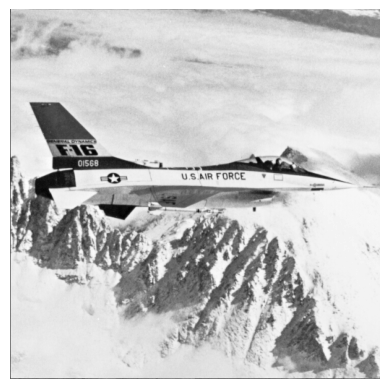

Image hash:  2fa4d44ec74a17c370f35ebbe5e728b54902553d9fb454f2f66f10d664ec7fdb
Devided image hash:  ['2fa4d44ec74a17c370f35ebbe5e728b5', '4902553d9fb454f2f66f10d664ec7fdb']
0.00079375
0.00078125
initial conditions:  0.001579375 0.001421875
00001100 11101001 01111000 11010101
Permuted image


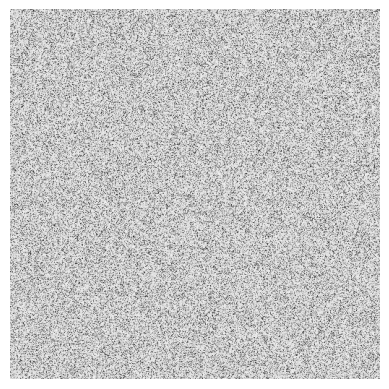

Encrypted image


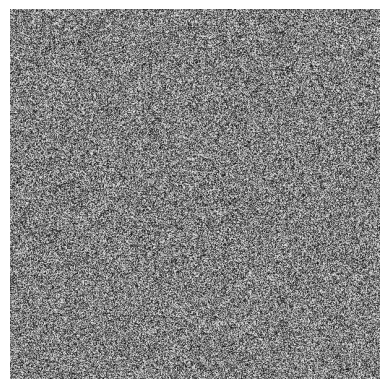

In [2]:
class proposed_prng_adpter:
    def __init__(self, initial_condition=0.1):
        self._initial_condition = initial_condition
    
    def get_time_series(self, num_iterations):
        chaotic_map = SineMapWithPertubation(control_parameter)
        return chaotic_map.get_iterations(self._initial_condition, num_iterations-1, posit_representation, verbose=False)

class ImageEncryption:
    def __init__(self, image_name, prng, base_dir="images/", verbose=False):
        self._image_name = image_name
        self._image_path = base_dir + image_name
        self._verbose = verbose
        self._prng = prng
        
    def read_image(self):
        self._img = cv2.imread(self._image_path, cv2.IMREAD_GRAYSCALE)
        return self._img
    
    def get_image_length(self, img):
        height, width = img.shape
        
        if self._verbose:
            print('height: ', height, 'width: ', width)

        return height * width
    
    def show_image(self, img, save_fig = False, filename='input_img.png'):
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if save_fig:
            plt.savefig(filename, format='png', bbox_inches='tight')
        plt.show()
    
    def get_hash(self, string):
        return hashlib.sha256(string.encode('utf-8')).hexdigest()
    
    def get_devided_hash(self, full_hash):
        length = len(full_hash)
        part_length = length // 2
        parts = [full_hash[i:i+part_length] for i in range(0, length, part_length)]
        return parts

    def hex_string_mean(self, hex_string):
        # Convert each pair of hexadecimal characters to their decimal representation
        decimal_values = [int(hex_string[i], 16) for i in range(0, len(hex_string))]
        
        # Compute the mean of the decimal values
        mean_value = sum(decimal_values) / len(decimal_values)

        return mean_value

    def permute_array(self, arr, indexes):
        return [arr[i] for i in indexes]

    def vector_to_matrix(self, vector, n, m):
        matrix = numpy.array(vector).reshape(n, m)
        return matrix

    def zeros_matrix(self, n, m):
        matrix = []
        for i in range(n):
            row = [0] * m
            matrix.append(row)
        return matrix

    def encrypt(self):
        img = self._img
        
        if self._verbose:
            print('Plan image')
            img_prefix_name = image_name.split('.')[0]
            self.show_image(img, save_fig = True, filename=f'output/{img_prefix_name}_plain.png')
        
        height, width = img.shape
        img_total_pixels = height * width
        img_vector = img.ravel()
        img_string = "".join(str(x) for x in img_vector)
        img_hash = self.get_hash(img_string)
        devided_image_hash = self.get_devided_hash(img_hash)
        
        if self._verbose:
            print('Image hash: ', img_hash)
            print('Devided image hash: ', devided_image_hash)
            print(self.hex_string_mean(devided_image_hash[0])/10000)
            print(self.hex_string_mean(devided_image_hash[1])/10000)
        initial_condition_1 = (0.0015 + (self.hex_string_mean(devided_image_hash[0])/100000)) % 1
        initial_condition_2 = (0.0015 - (self.hex_string_mean(devided_image_hash[1])/100000) + DIFF) % 1

        if self._verbose:
            print('initial conditions: ', initial_condition_1, initial_condition_2)
            posit_representation.get_number(initial_condition_2).toBinaryFormatted()
   
        prng_1 = self._prng(initial_condition_1)
        prng_2 = self._prng(initial_condition_2)

        pseudorandom_numbers_1 = prng_1.get_time_series(img_total_pixels)
        pseudorandom_numbers_2 = prng_2.get_time_series(img_total_pixels)
    
        indexes_sorted = numpy.argsort(pseudorandom_numbers_1)
        permuted_image_vector = self.permute_array(img_vector, indexes_sorted)
        permuted_image = self.vector_to_matrix(permuted_image_vector, height, width)

        if self._verbose:
            print('Permuted image')
            self.show_image(permuted_image)

        chipher_key = []
        encrypted_img = self.zeros_matrix(height, width)
        for j in range(height):
            for i in range(width):
                key = "{0:b}".format(pseudorandom_numbers_2[i + (j*width)].v.v).zfill(32)[-8:]
                chipher_key.append(key)
                encrypted_img[j][i] = int(key, 2) ^ permuted_image[j][i]
        
        if self._verbose:
            print('Encrypted image')
            img_prefix_name = image_name.split('.')[0]
            self.show_image(encrypted_img, save_fig = True, filename=f'output/{img_prefix_name}_cipher.png')
        
        return encrypted_img, permuted_image

class ImageMetrics:
    def plot_hist(self, image, title='', filename='hist.png'):
        image_flat = [pixel for row in image for pixel in row]
        plt.hist(image_flat, bins=256, color='blue')
        plt.xlabel('Pixel Value', fontsize=20)
        plt.ylabel('Frequency', fontsize=20)
        plt.title(title)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.savefig(filename, format='png', bbox_inches='tight')
        plt.show()

"""
ref: https://github.com/knowankit/Image-encryption-using-chaos-theory

Unified average avereage inensity changed rate

this code calculates average intensity change rate of pixels
"""
def uaci(loc1, loc2):
    height, width = numpy.shape(loc1)
    total_diff = 0.0
    max_pixel_value = 255.0  # assuming 8-bit images
    
    for y in range(width):
        for x in range(height):
            total_diff += abs(loc1[x][y] - loc2[x][y]) / max_pixel_value
    
    uaci_value = (total_diff / (width * height)) * 100
    return uaci_value

def sign(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    return 0

def npcr(loc1,loc2):
    pixel1=loc1
    pixel2=loc2
    height,width=numpy.shape(loc1)
    value=0.0
    for y in range(0,width):
        for x in range(0,height):
            value=(abs(sign(pixel1[x][y]-pixel2[x][y])))+value

    value=(value/(width*height))*100
    return value

def image_entropy(image_matrix):
    # Flatten the image matrix into a 1D array
    flat_image = numpy.array(image_matrix).flatten()

    # Calculate histogram of pixel intensities
    histogram, _ = numpy.histogram(flat_image, bins=256, range=(0, 256))

    # Normalize histogram to get probability distribution
    probability_distribution = histogram / float(numpy.sum(histogram))

    # Remove zero probabilities to avoid NaN values in entropy calculation
    probability_distribution = probability_distribution[probability_distribution != 0]

    # Calculate entropy
    entropy = -numpy.sum(probability_distribution * numpy.log2(probability_distribution))

    return entropy

def diff(loc1, loc2):
    height, width = numpy.shape(loc1)
    total_diff = 0.0
    
    for y in range(width):
        for x in range(height):
            total_diff += abs(sign(loc1[x][y] - loc2[x][y]))
    
    uaci_value = (total_diff / (width * height)) * 100
    return uaci_value

print("## Encrypyting image, generating histogram")
posit_representation = PositRepresentation(bit_length=32)
image_encryption_algorithm = ImageEncryption(image_name, proposed_prng_adpter, verbose=True)
original_image = image_encryption_algorithm.read_image()
encrypted_img, permuted_image = image_encryption_algorithm.encrypt()

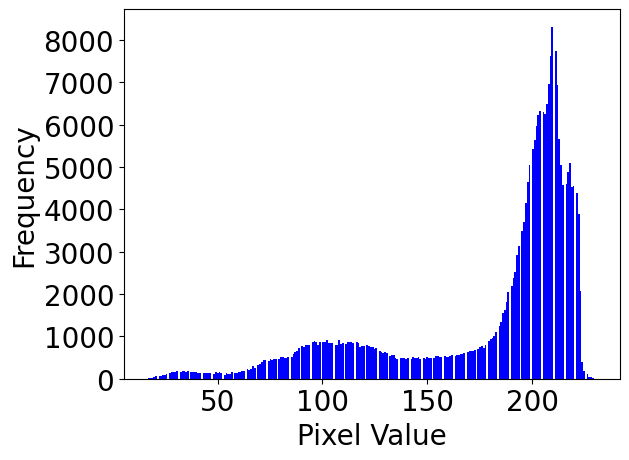

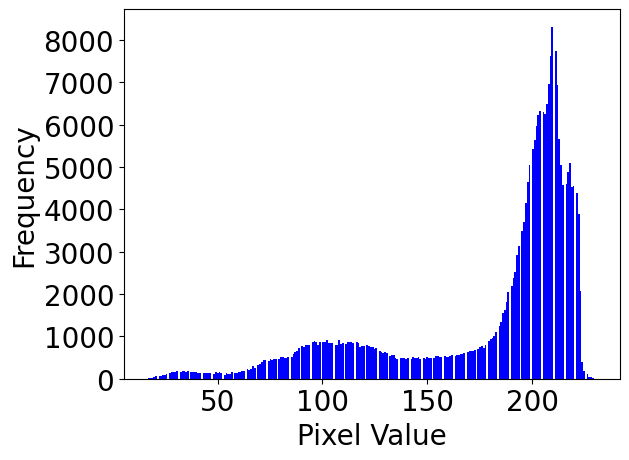

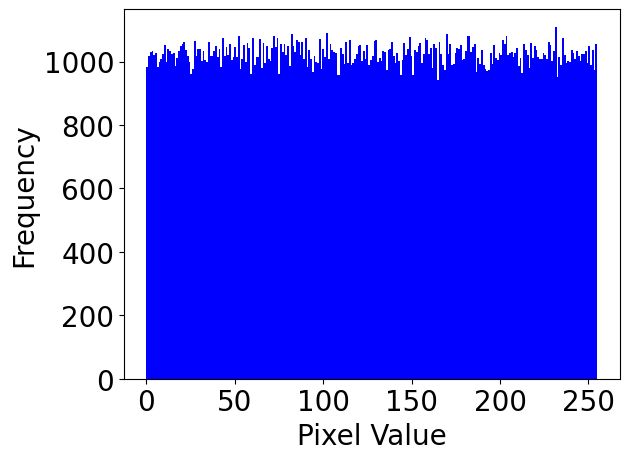

## Generating UACI, NPCR, entropy
Plan image


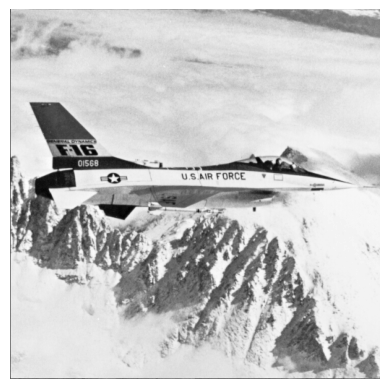

Image hash:  99de0922a6789b9b438b583eee79e871724fd7bfd60568f7befd6466045ec7c1
Devided image hash:  ['99de0922a6789b9b438b583eee79e871', '724fd7bfd60568f7befd6466045ec7c1']
0.000809375
0.000825
initial conditions:  0.0015809375 0.0014175
00001100 11100111 00101101 10100001
Permuted image


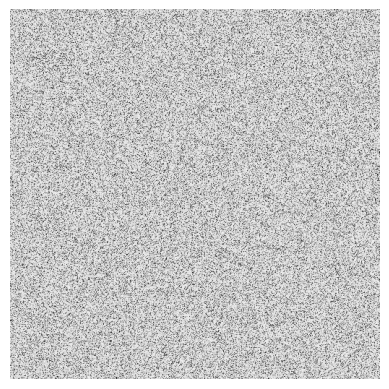

Encrypted image


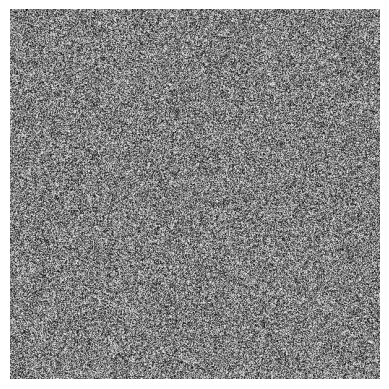

UACI:  33.47474490896072
NPCR:  99.5941162109375
entropy original image: 6.702443720781039
entropy chiper image: 7.999333557831878
## Computing diff +
Plan image


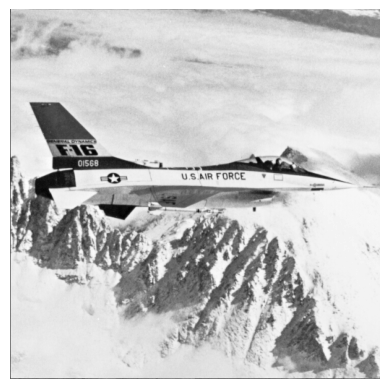

Image hash:  2fa4d44ec74a17c370f35ebbe5e728b54902553d9fb454f2f66f10d664ec7fdb
Devided image hash:  ['2fa4d44ec74a17c370f35ebbe5e728b5', '4902553d9fb454f2f66f10d664ec7fdb']
0.00079375
0.00078125
initial conditions:  0.001579375 0.0014228749999999999
00001100 11101001 11111111 00001101
Permuted image


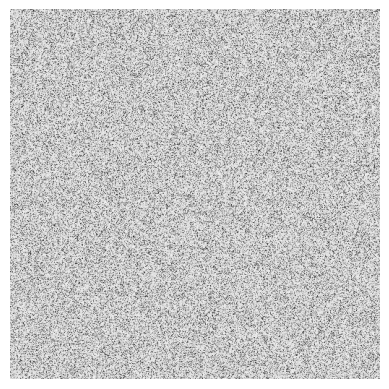

Encrypted image


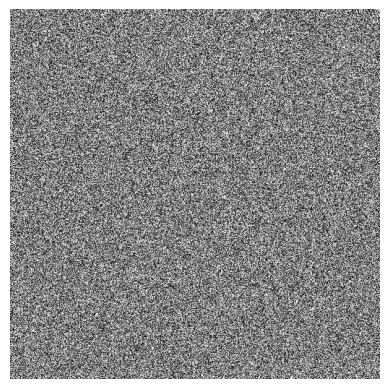

Diff: + 1e-06: 99.61280822753906
## Computing diff -
Plan image


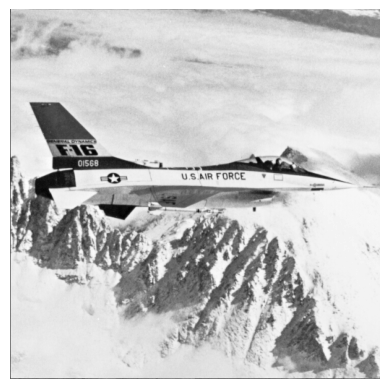

Image hash:  2fa4d44ec74a17c370f35ebbe5e728b54902553d9fb454f2f66f10d664ec7fdb
Devided image hash:  ['2fa4d44ec74a17c370f35ebbe5e728b5', '4902553d9fb454f2f66f10d664ec7fdb']
0.00079375
0.00078125
initial conditions:  0.001579375 0.001420875
00001100 11101000 11110010 10011101


In [ ]:
encrypted_img_software, permuted_image_software = encrypted_img, permuted_image

img_prefix_name = image_name.split('.')[0]
image_metrics = ImageMetrics()
image_metrics.plot_hist(original_image, filename=f'output/{img_prefix_name}_histogram.png')
image_metrics.plot_hist(permuted_image, filename=f'output/{img_prefix_name}_permuted_histogram.png')
image_metrics.plot_hist(encrypted_img, filename=f'output/{img_prefix_name}_cipher_histogram.png')

print("## Generating UACI, NPCR, entropy")

from random import randint

x = randint(0, numpy.array(encrypted_img).shape[0])
y = randint(0, numpy.array(encrypted_img).shape[1])

image_encryption_algorithm._img[x][y] = (image_encryption_algorithm._img[x][y] + 1) % 256
encrypted_img_2, permuted_image_2 = image_encryption_algorithm.encrypt()


print('UACI: ', uaci(encrypted_img_2, encrypted_img))
print('NPCR: ', npcr(encrypted_img_2, encrypted_img))

print("entropy original image:", image_entropy(original_image))
print("entropy chiper image:", image_entropy(encrypted_img))

print("## Computing diff +")

DIFF = 10 ** -6

image_encryption_algorithm = ImageEncryption(image_name, proposed_prng_adpter, verbose=True)
original_image = image_encryption_algorithm.read_image()
encrypted_img_plus_x0, permuted_image = image_encryption_algorithm.encrypt()

print(f"Diff: + {DIFF}: " + str(diff(encrypted_img, encrypted_img_plus_x0)))

print("## Computing diff -")

DIFF = - 10 ** -6

image_encryption_algorithm = ImageEncryption(image_name, proposed_prng_adpter, verbose=True)
original_image = image_encryption_algorithm.read_image()
encrypted_img_minus_x0, permuted_image = image_encryption_algorithm.encrypt()

print(f"Diff {DIFF}: " + str(diff(encrypted_img, encrypted_img_minus_x0)))


# Load images (assuming placontrol_parameterin.image, permuted.image, cipher.image are numpy arrays)
plain_image = original_image
permuted_imagepermuted_image = permuted_image
cipher_image = encrypted_img

plain_image = numpy.array(plain_image)
permuted_image = numpy.array(permuted_image)
cipher_image = numpy.array(cipher_image)

# Define Height and Width variables
Height = plain_image.shape[0]
Width = plain_image.shape[1]


aux_a = plain_image.T.astype(numpy.uint8)
aux_b = cipher_image.T.astype(numpy.uint8)

# Correlation coefficient
print('--------Correlation Coefficient - Plain Image---------')
A = aux_a.astype(float)
c_diag = numpy.corrcoef(A[:-1,:-1].ravel(), A[1:,1:].ravel())
c_vert = numpy.corrcoef(A[:-1,:].ravel(), A[1:,:].ravel())
c_horz = numpy.corrcoef(A[:,:-1].ravel(), A[:,1:].ravel())

print('plain image: ')
print(c_diag)
print(c_vert)
print(c_horz)

print('--------Correlation Coefficient - Cipher Image--------')
I = aux_b.astype(float)
c_diag2 = numpy.corrcoef(I[:-1,:-1].ravel(), I[1:,1:].ravel())
c_vert2 = numpy.corrcoef(I[:-1,:].ravel(), I[1:,:].ravel())
c_horz2 = numpy.corrcoef(I[:,:-1].ravel(), I[:,1:].ravel())
print('cipher image: ')
print(c_diag2)
print(c_vert2)
print(c_horz2)

### 2. Hardware-in-the-Loop implementation

Implementation using the PRNG implemented in hardware in VHDL.

In [ ]:
%matplotlib inline
import math
from abc import ABC, abstractmethod
import numpy
import matplotlib.pyplot as plt
import softposit as sp
import cv2
import hashlib
from random import random
from PIL import Image
import os

control_parameter = 0.962879
image_name = "airplane.tiff"
DIFF = 0

class hardware_chaotic_map:
    def __init__(self, initial_condition):
        self._initial_condition = initial_condition
    
    def _generate_numbers(self):
        with open("/home/samuel/src/PositPRNG/src/pseudorandom_generator/input_A.txt", "w") as f:
            f.write("{0:b}".format(self._initial_condition.v.v).zfill(32))
        
        os.system("cd /home/samuel/src/PositPRNG/src/pseudorandom_generator/ && vsim -do \"tb_script.do\"")  # Runs the 'dir' command in CMD
        
    def get_time_series(self, num):
        print('num pixels:', num)
        self._generate_numbers()

class HilImageEncryption:
    def __init__(self, image_name, base_dir="images/", verbose=False):
        self._image_name = image_name
        self._image_path = base_dir + image_name
        self._verbose = verbose
        
    def read_image(self):
        #self._img = cv2.imread(self._image_path, cv2.IMREAD_UNCHANGED)
        self._img = cv2.imread(self._image_path, cv2.IMREAD_GRAYSCALE)
        return self._img
    
    def get_image_length(self, img):
        height, width = img.shape
        
        if self._verbose:
            print('height: ', height, 'width: ', width)

        return height * width
    
    def show_image(self, img, save_fig = False, filename='input_img.png'):
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if save_fig:
            plt.savefig(filename, format='png', bbox_inches='tight')
        plt.show()
    
    def get_hash(self, string):
        return hashlib.sha256(string.encode('utf-8')).hexdigest()
    
    def get_devided_hash(self, full_hash):
        length = len(full_hash)
        part_length = length // 2
        parts = [full_hash[i:i+part_length] for i in range(0, length, part_length)]
        return parts

    def hex_string_mean(self, hex_string):
        # Convert each pair of hexadecimal characters to their decimal representation
        decimal_values = [int(hex_string[i], 16) for i in range(0, len(hex_string))]
        
        # Compute the mean of the decimal values
        mean_value = sum(decimal_values) / len(decimal_values)

        return mean_value

    def permute_array(self, arr, indexes):
        return [arr[i] for i in indexes]

    def vector_to_matrix(self, vector, n, m):
        matrix = numpy.array(vector).reshape(n, m)
        return matrix

    def zeros_matrix(self, n, m):
        matrix = []
        for i in range(n):
            row = [0] * m
            matrix.append(row)
        return matrix

    def encrypt(self):
        img = self._img
        
        if self._verbose:
            print('Plan image')
            img_prefix_name = image_name.split('.')[0]
            self.show_image(img, save_fig = True, filename=f'output/{img_prefix_name}_plain.png')
        
        height, width = img.shape
        img_total_pixels = height * width
        img_vector = img.ravel()
        img_string = "".join(str(x) for x in img_vector)
        img_hash = self.get_hash(img_string)
        devided_image_hash = self.get_devided_hash(img_hash)
        
        if self._verbose:
            print('Image hash: ', img_hash)
            print('Devided image hash: ', devided_image_hash)
            print(self.hex_string_mean(devided_image_hash[0])/10000)
            print(self.hex_string_mean(devided_image_hash[1])/10000)
        initial_condition_1 = sp.posit32((0.0015 + (self.hex_string_mean(devided_image_hash[0])/100000)) % 1)
        initial_condition_2 = sp.posit32((0.0015 - (self.hex_string_mean(devided_image_hash[1])/100000) + DIFF) % 1)
        initial_condition_1_binary = "{0:b}".format(initial_condition_1.v.v).zfill(32)
        initial_condition_2_binary = "{0:b}".format(initial_condition_2.v.v).zfill(32)
        
        if self._verbose:
            print('initial conditions: ', initial_condition_1, initial_condition_2)
            print('initial consitions:', initial_condition_1_binary, initial_condition_2_binary)
   
        pseudorandom_numbers_1 = []
        pseudorandom_numbers_2 = []

        with open("/home/samuel/src/PositPRNG/src/pseudorandom_generator/output_S_1.txt", "r") as file:
            for i, line in enumerate(file):
                if i >= img_total_pixels:
                    break
                pseudorandom_numbers_1.append(sp.posit32(bits=int(line.strip(),2)))
                
        with open("/home/samuel/src/PositPRNG/src/pseudorandom_generator/output_S_2.txt", "r") as file:
            for i, line in enumerate(file):
                if i >= img_total_pixels:
                    break
                pseudorandom_numbers_2.append(sp.posit32(bits=int(line.strip(),2)))
        
        indexes_sorted = numpy.argsort(pseudorandom_numbers_1)
        permuted_image_vector = self.permute_array(img_vector, indexes_sorted)
        permuted_image = self.vector_to_matrix(permuted_image_vector, height, width)

        if self._verbose:
            print('Permuted image')
            self.show_image(permuted_image)

        chipher_key = []
        encrypted_img = self.zeros_matrix(height, width)
        for j in range(height):
            for i in range(width):
                key = "{0:b}".format(pseudorandom_numbers_2[i + (j*width)].v.v).zfill(32)[-8:]
                chipher_key.append(key)
                encrypted_img[j][i] = int(key, 2) ^ permuted_image[j][i]
        
        if self._verbose:
            print('Encrypted image')
            img_prefix_name = image_name.split('.')[0]
            self.show_image(encrypted_img, save_fig = True, filename=f'output/{img_prefix_name}_cipher.png')
        
        return encrypted_img, permuted_image

print("## Encrypyting image, generating histogram")
posit_representation = PositRepresentation(bit_length=32)
image_encryption_algorithm = HilImageEncryption(image_name, verbose=True)
original_image = image_encryption_algorithm.read_image()
encrypted_img_hardware, permuted_image_hardware = image_encryption_algorithm.encrypt()